In [1]:
library(magrittr)
library(tidyverse)
library(patchwork)
theme_set(theme_bw(base_size=12) + theme(panel.grid=element_blank(), 
                             panel.border=element_blank(), 
                             axis.title=element_blank(), 
                             axis.text=element_blank(), 
                             axis.line = element_line(arrow=arrow(length=unit(2, "mm"))),
                             strip.text = element_text(size=12),
                             strip.background=element_blank()))

library(Matrix)

library(SingleCellExperiment)
library(scran)
library(scater)

library(scutility)
library(multisce)

library(UCell)
library(pheatmap)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()

Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The follow

In [2]:
sce <- multisce_load(path=here::here("data", "multisce", "SS17_blood"), main_name="RNA", reduceddim_include="umap", altexp_include="ADT", metadata_include="colors")

Loading RNA from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/sce/RNA.rds

Loading coldata from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/coldata.rds

Loading colors from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/metadata/colors.rds

Loading ADT from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/sce/ADT.rds

Loading umap from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_blood/reducedDim/umap.rds



In [3]:
group_to_short <- c("PBS_DMSO"="DMSO",
                    "PBS_Romidepsin"="Ro",
                    "SE_DMSO"="SE",
                    "SE_Romidepsin"="SE+Ro")

sce$group_short <- group_to_short[as.character(sce$group)]
metadata(sce)$colors[["group_short"]] <- c("DMSO"="grey", "Ro"="#009900", "SE"="#CC0000", "SE+Ro"="orange")

sce$group_short %<>% factor(levels=names(metadata(sce)$colors[["group_short"]]))

### Load Romidepsin resistance genesets

From Andrews et al. 2019 (https://doi.org/10.1016/j.ebiom.2019.07.053)

In [4]:
Pathways <- readxl::read_xlsx(here::here("include", "Andrews_2019_TableS6_Resistance_genesets.xlsx"))
Pathways %<>% filter(RPGgroup %in% c("ABCtransporters", "MAPK_PI3K", "NFKB", "JAK_STAT"))

signatures <- Pathways %>% group_by(RPGgroup) %>% group_map(~ .x %>% pull(GeneName))
names(signatures) <- sort(unique(Pathways$RPGgroup))
signatures

$ABCtransporters
 [1] "ABCA1"     "ABCA10"    "ABCA11P"   "ABCA12"    "ABCA13"    "ABCA17P"  
 [7] "ABCA2"     "ABCA3"     "ABCA4"     "ABCA5"     "ABCA6"     "ABCA7"    
[13] "ABCA8"     "ABCA9"     "ABCB1"     "ABCB10"    "ABCB4"     "ABCB5"    
[19] "ABCB6"     "ABCB7"     "ABCB8"     "ABCB9"     "ABCC1"     "ABCC10"   
[25] "ABCC11"    "ABCC12"    "ABCC13"    "ABCC2"     "ABCC3"     "ABCC4"    
[31] "ABCC5"     "ABCC5-AS1" "ABCC6"     "ABCC6P1"   "ABCC8"     "ABCC9"    
[37] "ABCD1"     "ABCD2"     "ABCD3"     "ABCD4"     "ABCE1"     "ABCF1"    
[43] "ABCF2"     "ABCF3"     "ABCG1"     "ABCG2"     "ABCG4"     "ABCG5"    

$JAK_STAT
 [1] "STAT1"  "STAT2"  "STAT3"  "STAT4"  "STAT5A" "STAT5B" "STAT6"  "JAK1"  
 [9] "JAK2"   "JAK3"  

$MAPK_PI3K
 [1] "MAPK1"        "MAPK10"       "MAPK11"       "MAPK12"       "MAPK13"      
 [6] "MAPK14"       "MAPK1IP1L"    "MAPK3"        "MAPK4"        "MAPK6"       
[11] "MAPK7"        "MAPK8"        "MAPK8IP1"     "MAPK8IP3"     "MAPK9"       
[16] "MAPKAP1"      "MAPKAPK2"     "MAPKAPK3"     "MAPKAPK5"     "MAPKAPK5-AS1"
[21] "MAPKBP1"      "MAP2K1"       "MAP2K2"       "MAP2K3"       "MAP2K4"      
[26] "MAP2K4P1"     "MAP2K5"       "MAP2K6"       "MAP2K7"       "PIK3C2A"     
[31] "PIK3C2B"      "PIK3C2G"      "PIK3C3"       "PIK3CA"       "PIK3CB"      
[36] "PIK3CD"       "PIK3CG"      

$NFKB
 [1] "NFKB1"   "NFKB2"   "NFKBIA"  "NFKBIB"  "NFKBID"  "NFKBIE"  "NFKBIL1"
 [8] "NFKBIZ"  "RELA"    "RELB"    "IKBIP"   "IKBKAP"  "IKBKB"   "IKBKE"  
[15] "IKBKG"

### Romidepsin resistant versus sensitive CTCL patients gene-sets
Extract Romidepsin resistance signatures from up and down differentially expressed genes from CD4 T cells compared between resistant and sensitive patients

Only include genes that are statistically significantly (padj <= 0.05) differentially expressed with a difference larger than four fold and a high base expression.

In [5]:
Romi_res <- readxl::read_xlsx(here::here("include", "Andrews_2019_TableS4_Romi_resistance_DEG.xlsx"))
Romi_res %>% head

Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,CTCL1043.CD4P_CD7N.POST,CTCL992.CD4P.FU,CTCL1084.CD4P_CD7N.OW,CTCL992.CD4P_CD7N.OW,⋯,CTCL1135.CD4P.POST,CTCL1234.SKIN.UNSORTED.POST,CTCL409.CD4P.POST,CTCL1145.CD4P.VOR_POST,Vol1.CD4P.Romi,Vol1.CD4P.Untreated,Vol2.CD4P.Romi,Vol2.CD4P.Untreated,Vol3.CD4P.Romi,Vol3.CD4P.Untreated
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AX747516,305.03448,-6.654914,0.9876843,4.647150e-15,4.857202e-11,14.3144371,9131.664126,7.7427697,8.2874991,⋯,2.953768,3.330211,0.6585427,5.285793,13.4302091,7.119504,9.543947,0.6352256,1.3997278,7.314105
CD7,175.69223,4.289334,0.5825955,2.591275e-15,4.857202e-11,3.6841786,47.849535,1.5377871,6.5032128,⋯,79.015674,132.708827,635.5336284,69.252421,129.0317271,600.321430,107.345003,358.7964672,124.8920555,603.040969
C15orf38-AP3S2,42.19379,23.098653,3.0530086,7.856464e-15,5.474384e-11,0.0000000,0.000000,0.0000000,0.0000000,⋯,0.000000,0.000000,0.0000000,368.153249,0.0000000,0.000000,0.000000,0.0000000,0.0000000,7.735515
UBE2NL,73.12961,-6.495352,1.1217111,2.425783e-12,1.267714e-08,1.2715575,1.097863,0.8280752,0.8072206,⋯,1.619859,4.364817,1.5833913,2.380862,0.8252622,4.292650,2.496178,0.7102813,0.5499471,1.795830
ATP8B5P,946.00658,7.163022,1.3572346,2.623970e-11,1.097029e-07,5.1922610,2.328294,1.7607303,0.8943860,⋯,1.594873,1.049462,1.0056729,5392.592634,4067.7039522,3279.074309,4488.388849,2479.8069617,2.8243842,1814.554656
RBM11,59.97644,3.717143,0.6173275,6.352598e-11,2.213245e-07,0.9555657,3.366786,6.8104438,1.8350288,⋯,71.655201,67.632791,139.8758228,16.762346,292.0229414,91.619566,236.897451,68.6991184,357.4518871,83.986364


In [6]:
signatures %<>% append(list("Romi_res_down"=Romi_res %>% filter(baseMean >= 100 & log2FoldChange <= -2 & padj <= 0.05) %>% pull(Gene) %>% intersect(rownames(sce)),
                       "Romi_res_up"=Romi_res %>% filter(baseMean >= 100 & log2FoldChange >= 2 & padj <= 0.05) %>% pull(Gene) %>% intersect(rownames(sce))))

signatures

$ABCtransporters
 [1] "ABCA1"     "ABCA10"    "ABCA11P"   "ABCA12"    "ABCA13"    "ABCA17P"  
 [7] "ABCA2"     "ABCA3"     "ABCA4"     "ABCA5"     "ABCA6"     "ABCA7"    
[13] "ABCA8"     "ABCA9"     "ABCB1"     "ABCB10"    "ABCB4"     "ABCB5"    
[19] "ABCB6"     "ABCB7"     "ABCB8"     "ABCB9"     "ABCC1"     "ABCC10"   
[25] "ABCC11"    "ABCC12"    "ABCC13"    "ABCC2"     "ABCC3"     "ABCC4"    
[31] "ABCC5"     "ABCC5-AS1" "ABCC6"     "ABCC6P1"   "ABCC8"     "ABCC9"    
[37] "ABCD1"     "ABCD2"     "ABCD3"     "ABCD4"     "ABCE1"     "ABCF1"    
[43] "ABCF2"     "ABCF3"     "ABCG1"     "ABCG2"     "ABCG4"     "ABCG5"    

$JAK_STAT
 [1] "STAT1"  "STAT2"  "STAT3"  "STAT4"  "STAT5A" "STAT5B" "STAT6"  "JAK1"  
 [9] "JAK2"   "JAK3"  

$MAPK_PI3K
 [1] "MAPK1"        "MAPK10"       "MAPK11"       "MAPK12"       "MAPK13"      
 [6] "MAPK14"       "MAPK1IP1L"    "MAPK3"        "MAPK4"        "MAPK6"       
[11] "MAPK7"        "MAPK8"        "MAPK8IP1"     "MAPK8IP3"     "MAPK9"       
[16] "MAPKAP1"      "MAPKAPK2"     "MAPKAPK3"     "MAPKAPK5"     "MAPKAPK5-AS1"
[21] "MAPKBP1"      "MAP2K1"       "MAP2K2"       "MAP2K3"       "MAP2K4"      
[26] "MAP2K4P1"     "MAP2K5"       "MAP2K6"       "MAP2K7"       "PIK3C2A"     
[31] "PIK3C2B"      "PIK3C2G"      "PIK3C3"       "PIK3CA"       "PIK3CB"      
[36] "PIK3CD"       "PIK3CG"      

$NFKB
 [1] "NFKB1"   "NFKB2"   "NFKBIA"  "NFKBIB"  "NFKBID"  "NFKBIE"  "NFKBIL1"
 [8] "NFKBIZ"  "RELA"    "RELB"    "IKBIP"   "IKBKAP"  "IKBKB"   "IKBKE"  
[15] "IKBKG"  

$Romi_res_down
 [1] "CD160"     "IFNG"      "LINC00885" "UNC5CL"    "PPM1H"     "CCL5"     
 [7] "CYB561"    "RHOU"      "KCNMA1"    "ZNF683"   

$Romi_res_up
 [1] "CD7"       "AP1M2"     "TCL1A"     "HLA-G"     "IFI27"     "S100B"    
 [7] "PARD3B"    "LAIR2"     "PHGDH"     "RAB25"     "RASGRF2"   "CKAP2L"   
[13] "EPCAM"     "BAG2"      "IGHG1"     "NRP2"      "STAP1"     "PLXNA4"   
[19] "HMMR"      "CDCA7L"    "IGFL2"     "AUTS2"     "MEST"      "AR"       
[25] "CDC45"     "GINS2"     "PRKCQ-AS1" "CDC20"     "C6orf201"  "CCNB2"    
[31] "IGKV3-11"  "CDK1"      "SUSD4"     "TYMS"      "TRDC"      "PERP"     
[37] "CCR6"      "VCAM1"     "MZB1"      "ARHGAP32"  "C1QC"      "MYBL2"    
[43] "DEFA1"     "ANXA3"     "GSTM1"     "MS4A3"     "CTSG"      "DEFA4"    
[49] "CXCL10"    "GOLGA8G"   "ITGA11"    "TCN1"

Calculate geneset scores for each cell using UCell package (https://doi.org/10.1016/j.csbj.2021.06.043)

In [7]:
uscores <- ScoreSignatures_UCell(counts(sce), features = signatures)

Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* ABCA11P,ABCA17P,ABCC13,ABCC6P1,MAP2K4P1,IKBKAP”


In [8]:
# Add geneset scores to colData
colData(sce) %<>% cbind(uscores %>% as.data.frame())

In [9]:
colnames(colData(sce)) %<>% gsub("\\-", "_", .)

summarize mean gene-set scores for malignant T cells within each sample condition

In [10]:
data_plot <- colData(sce)[sce$cell_type == "Malignant", c(paste0(gsub("\\-", "_", names(signatures)), "_UCell"), "group_short")] %>% as.data.frame() %>% 
    group_by(group_short) %>% summarize(across(ends_with("UCell"), mean))

colnames(data_plot) %<>% gsub("_UCell", "", .)
data_plot

group_short,ABCtransporters,JAK_STAT,MAPK_PI3K,NFKB,Romi_res_down,Romi_res_up
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DMSO,0.02347773,0.1748476,0.04098840,0.05627946,0.006717985,0.01259609
Ro,0.02540857,0.1481069,0.04447067,0.04383122,0.004573333,0.01159556
SE,0.02159895,0.2272308,0.03106320,0.11291955,0.001429395,0.01843761
SE+Ro,0.01862621,0.2432037,0.03405084,0.10375290,0.002082219,0.01481026


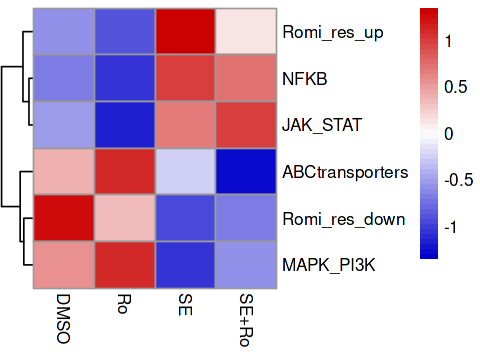

In [11]:
options(repr.plot.width=4, repr.plot.height=3)
data_plot %>% ungroup() %>%  select(group_short, Romi_res_up, Romi_res_down, ABCtransporters, MAPK_PI3K, NFKB, JAK_STAT) %>% mutate(group_short=gsub("_UCell", "", group_short)) %>% tibble::column_to_rownames("group_short") %>% as.matrix() %>% t() %>% 
    pheatmap(scale="row", cluster_cols=FALSE, 
             show_colnames=TRUE,
             treeheight_row=15,
             color=colorRampPalette(colors = c("#0000CC", "white","#CC0000"))(50)) %>% 
    ggplotify::as.ggplot() %>% ggsave(filename=here::here("data", "figures", "Romi_resistance_genesets_heatmap.pdf"), height=2, width=4)